In [6]:
import pandas as pd
import numpy as np
import sklearn
import datetime
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
# date parse format
def dateparse (time_in_secs):    
    return datetime.datetime.fromtimestamp(float(time_in_secs))

In [8]:
rating_dt = pd.read_csv('../data/ratings.csv', 
                        #parse_dates=['timestamp'], 
                        #date_parser=dateparse
                       )
movie_dt = pd.read_csv('../data/movies.csv')
tag_dt = pd.read_csv('../data/tags.csv', parse_dates=['timestamp'])

In [28]:
print(tag_dt.info())
print(movie_dt.info())
print(rating_dt.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1108997 entries, 0 to 1108996
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   userId     1108997 non-null  int64 
 1   movieId    1108997 non-null  int64 
 2   tag        1108981 non-null  object
 3   timestamp  1108997 non-null  object
dtypes: int64(2), object(2)
memory usage: 33.8+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58098 entries, 0 to 58097
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  58098 non-null  int64 
 1   title    58098 non-null  object
 2   genres   58098 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.3+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27753444 entries, 0 to 27753443
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3  

### Neural Collaborative Filtering

#### Prepare data

In [10]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [14]:
# all unique user ids
user_ids = rating_dt["userId"].unique().tolist() 
num_all_user = len(user_ids)

# randomly select 20% users from rating dataset 
np.random.seed(123)
rand_userid = np.random.choice(user_ids, size = int(num_all_user * 0.1), replace=False)
sample_df = rating_dt.loc[rating_dt['userId'].isin(rand_userid)]

# userid, movieid encoding by indices
user_ids = sample_df['userId'].unique()
num_users = len(user_ids)
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
user_encoded2user = {i: x for i, x in enumerate(user_ids)}
sample_df['user_encoded'] = sample_df['userId'].map(user2user_encoded)

movie_ids = sample_df['movieId'].unique()
num_movies = len(movie_ids)
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}
sample_df['movie_encoded'] = sample_df['movieId'].map(movie2movie_encoded)

# train-test split
train, test = train_test_split(sample_df, test_size = 0.2, random_state=123)

num_train_user = len(np.unique(train['user_encoded']))
num_train_movie = len(np.unique(train['movie_encoded']))

print(f'total movie: {num_movies}', 
      f'\nmovie in train: {num_train_movie}', 
      f'\nmovie not in train: {num_movies - num_train_movie} ({1 - num_train_movie / num_movies :.2f})', 
      f'\n\ntotal user: {num_users}', 
      f'\nuser in train: {num_train_user}', 
      f'\nuser not in train: {num_users - num_train_user} ({1 - num_train_user / num_users :.2f})'
     )

<ipython-input-14-9c7dba4cb887>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_df['user_encoded'] = sample_df['userId'].map(user2user_encoded)
<ipython-input-14-9c7dba4cb887>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_df['movie_encoded'] = sample_df['movieId'].map(movie2movie_encoded)


total movie: 27374 
movie in train: 25680 
movie not in train: 1694 (0.06) 

total user: 28322 
user in train: 28177 
user not in train: 145 (0.01)


#### Embedding and model

In [16]:
from keras.models import Model, Sequential
from keras.layers import Embedding, Flatten, Input, merge, Dropout, Dense, BatchNormalization, concatenate, dot
from keras.optimizers import Adam
from keras.utils import plot_model, model_to_dot
from keras.constraints import non_neg
from IPython.display import SVG
from sklearn.metrics import mean_squared_error
import os

In [17]:
# input: an integer as embedding layer size, a float as drop out probability
# output: a keras NCF model with pre-constructed layers
def NCF_model(embed_size = 10, drop_out_prob = 0.2): 
    # define spaceholder of embedding inputs
    movie_input = Input(shape=[1],name='movie-input')
    user_input = Input(shape=[1], name='user-input')

    # MLP embeddings for both user and movie
    movie_embedding_mlp = Embedding(num_movies, embed_size, 
                                    name='movie-embedding-mlp')(movie_input)
    movie_vec_mlp = Flatten(name='flatten-movie-mlp')(movie_embedding_mlp)
    movie_vec_mlp = Flatten(name='flatten-movie-mlp')(movie_embedding_mlp)

    user_embedding_mlp = Embedding(num_users, embed_size, 
                                   name='user-embedding-mlp')(user_input)
    user_vec_mlp = Flatten(name='flatten-user-mlp')(user_embedding_mlp)

    # MF embeddings for both user and movie
    movie_embedding_mf = Embedding(num_movies, embed_size, 
                                   name='movie-embedding-mf')(movie_input)
    movie_vec_mf = Flatten(name='flatten-movie-mf')(movie_embedding_mf)

    user_embedding_mf = Embedding(num_users, embed_size, 
                                  name='user-embedding-mf')(user_input)
    user_vec_mf = Flatten(name='flatten-user-mf')(user_embedding_mf)

    # MLP layers
    concat = concatenate([movie_vec_mlp, user_vec_mlp], axis=-1, name='concat')
    concat_dropout = Dropout(drop_out_prob)(concat)

    fc_1 = Dense(100, name='fc-1', activation='relu')(concat_dropout)
    fc_1_bn = BatchNormalization(name='batch-norm-1')(fc_1)
    fc_1_dropout = Dropout(drop_out_prob)(fc_1_bn)

    fc_2 = Dense(50, name='fc-2', activation='relu')(fc_1_dropout)
    fc_2_bn = BatchNormalization(name='batch-norm-2')(fc_2)
    fc_2_dropout = Dropout(drop_out_prob)(fc_2_bn)

    # Prediction from both layers
    pred_mlp = Dense(10, name='pred-mlp', activation='relu')(fc_2_dropout)
    pred_mf = dot([movie_vec_mf, user_vec_mf], axes=1, normalize=False)

    combine_mlp_mf = concatenate([pred_mf, pred_mlp], axis=-1, name='pred_mf')

    # Final prediction
    result = Dense(1, name='result', activation='relu')(combine_mlp_mf)

    model = Model([user_input, movie_input], result)
    model.compile(optimizer=Adam(lr=0.01), loss='mean_squared_error')

    return model

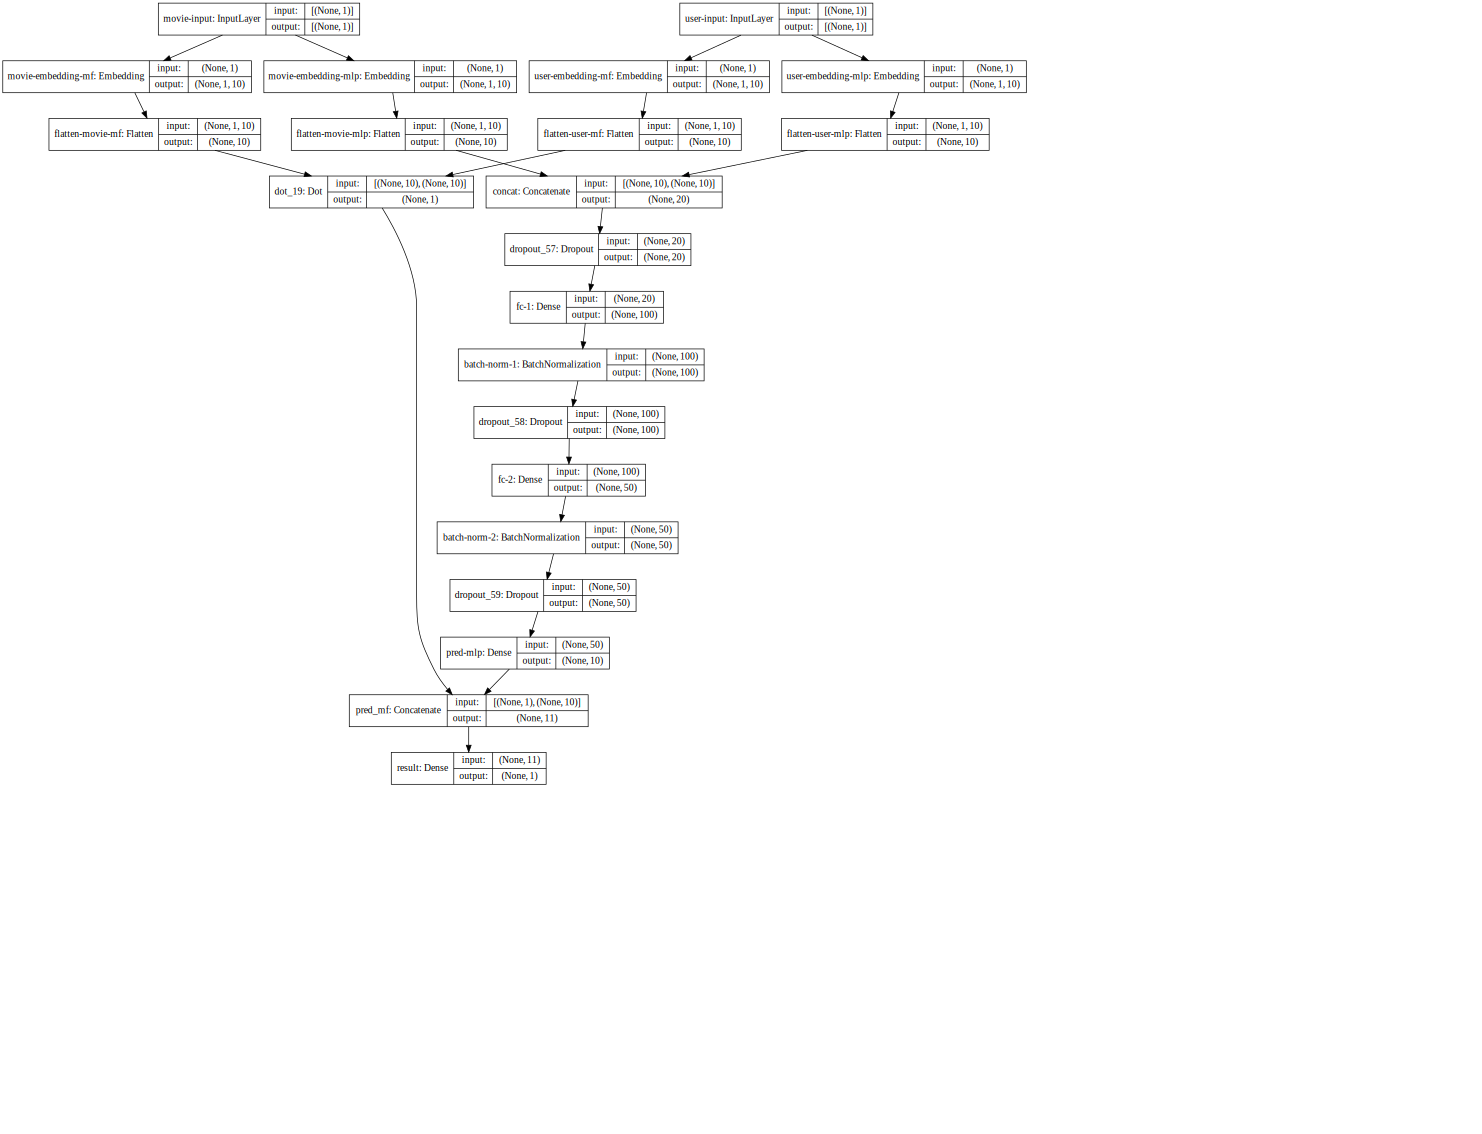

In [246]:
model = NCF_model()

# set plotmodel path
os.environ["PATH"] += os.pathsep + "/usr/bin/dot"

# plot NCF model architecture
SVG(model_to_dot(model, dpi=50, show_shapes=True).create(prog='dot', format='svg'))

In [245]:
model.summary()

Model: "model_18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
movie-input (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
user-input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
movie-embedding-mlp (Embedding) (None, 1, 20)        547480      movie-input[0][0]                
__________________________________________________________________________________________________
user-embedding-mlp (Embedding)  (None, 1, 20)        566440      user-input[0][0]                 
___________________________________________________________________________________________

Epoch 1/5
68025/68025 [==============================] - 356s 5ms/step - loss: 0.9361
Epoch 2/5
68025/68025 [==============================] - 358s 5ms/step - loss: 0.7943
Epoch 3/5
68025/68025 [==============================] - 361s 5ms/step - loss: 0.7716
Epoch 4/5
68025/68025 [==============================] - 361s 5ms/step - loss: 0.7606
Epoch 5/5
68025/68025 [==============================] - 362s 5ms/step - loss: 0.7539


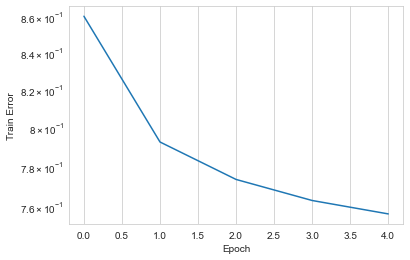

In [25]:
# train NCF model on training data, embedding size 20, dropout rate as default
model = NCF_model(embed_size=20)
history = model.fit([train['user_encoded'], train['movie_encoded']], train['rating'], epochs=5)

pd.Series(history.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Train Error")
plt.show()

In [12]:
# uncomment to save model as 'dl_model.h5'
## model.save('dl_model.h5')

# uncomment to load model
from keras.models import load_model
model = load_model('dl_model.h5')

In [17]:
# rmse on testing set 
y_hat = np.round(model.predict([test['user_encoded'], test['movie_encoded']]), decimals=2)
y_true = test['rating']
print(f'testing rms: {mean_squared_error(y_true, y_hat)}')

testing rms: 0.7339502329149826


In [28]:
# prediction sample
d = {'prediction': y_hat.tolist(), 'true_value': y_true.values.tolist()}
test_pred = pd.DataFrame(d)
test_pred.head(5)

,prediction,true_value
0,[2.930000066757202],3.0
1,[3.049999952316284],4.0
2,[3.5],3.5
3,[3.880000114440918],4.0
4,[4.0],3.0


#### Performance on inactive / active users

In [35]:
# count number of ratings for all users
user_counts = sample_df.groupby('userId').size()

[(0.0, 6000.0),
 (0.0, 400.0),
 Text(0.5, 1.0, 'Distribution of User Ratings'),
 Text(0.5, 0, 'Number of Ratings')]

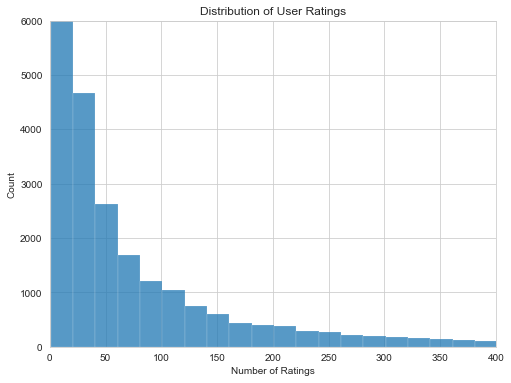

In [43]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.set_style('whitegrid')

sns.histplot(user_counts, binwidth=20, ax=ax)
ax.set(ylim=[0,6000], xlim=[0,400], title='Distribution of User Ratings', xlabel='Number of Ratings')

In [73]:
# classify user base on counts of rating
active_levels = ['<10', '10-20', '20-50', '50-80', '80-150', '>150']

user_counts_levels = dict.fromkeys(active_levels, None)
user_counts_levels['<10'] = user_counts[user_counts < 10]
user_counts_levels['10-20'] = user_counts[(user_counts >= 10) & (user_counts < 20)]
user_counts_levels['20-50'] = user_counts[(user_counts >= 20) & (user_counts < 50)]
user_counts_levels['50-80'] = user_counts[(user_counts >= 50) & (user_counts < 80)]
user_counts_levels['80-150'] = user_counts[(user_counts >= 80) & (user_counts < 150)]
user_counts_levels['>150'] = user_counts[user_counts >= 150]

In [ ]:
# calculate rmse for all groups of user
user_level_rmse = []
for key in active_levels:
    indices = user_counts_levels[key].index.tolist()
    pred_df = sample_df[sample_df['userId'].isin(indices)]
    y_true = pred_df['rating']
    y_pred = model.predict([pred_df['user_encoded'], pred_df['movie_encoded']])
    user_level_rmse.append(mean_squared_error(y_true, y_pred))

[[Text(0, 0, '<10'),
  Text(1, 0, '10-20'),
  Text(2, 0, '20-50'),
  Text(3, 0, '50-80'),
  Text(4, 0, '80-150'),
  Text(5, 0, '>150')],
 Text(0.5, 0, 'Number of ratings'),
 Text(0, 0.5, 'rmse')]

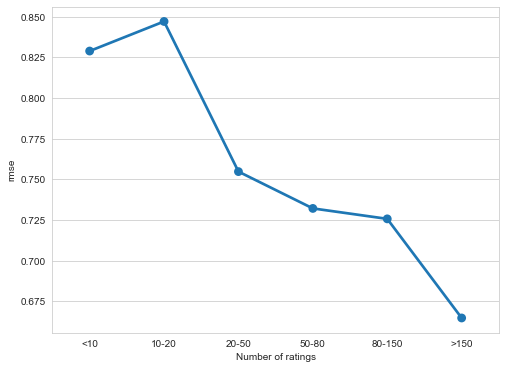

In [113]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.set_style('whitegrid')

sns.pointplot(y=user_level_rmse, x=np.arange(6))
ax.set(xticklabels=active_levels, xlabel='Number of ratings', ylabel='rmse')

#### Cross-validation on validation set

In [14]:
from sklearn.model_selection import KFold

# sample 100k from training set as validation set 
valid_df_size = 100000
valid_df = train.sample(n = int(valid_df_size), replace=False, random_state=123)

embedding_layers = [5, 10, 15, 20, 25, 30]

In [15]:
# input: validation data set, list of embedding layer size, drop-out probability, number of epochs, number of fold
# output: list of cv-rmse for each hyperparameter value
def NCF_cross_validation(cv_df, eb_layers, drop_prob = 0.2, epoch=3, n_split=3):
    cv_result = []

    for el in eb_layers:      
        temp_loss = []
        itr_idx = 0
        
        for train_idx, test_idx in KFold(n_split).split(cv_df):          
            cv_train_x = cv_df.iloc[train_idx][['user_encoded', 'movie_encoded']]
            cv_test_x = cv_df.iloc[test_idx][['user_encoded', 'movie_encoded']]
            cv_train_y = cv_df.iloc[train_idx]['rating']
            cv_test_y = cv_df.iloc[test_idx]['rating']

            model_cv = NCF_model()
            model_cv.fit([cv_train_x['user_encoded'], cv_train_x['movie_encoded']], cv_train_y, epochs=epoch)

            curr_loss = model_cv.evaluate([cv_df['user_encoded'], cv_df['movie_encoded']], cv_df['rating'])
            temp_loss.append(curr_loss)         
            itr_idx += 1
            
        cv_result.append(sum(temp_loss) / n_split)
            
    return cv_result

In [18]:
cv_result = NCF_cross_validation(valid_df, embedding_layers)

Epoch 1/3
2084/2084 [==============================] - 6s 3ms/step - loss: 1.4372
Epoch 2/3
2084/2084 [==============================] - 5s 3ms/step - loss: 0.9346
Epoch 3/3
3125/3125 [==============================] - 1s 406us/step - loss: 0.5877
Epoch 1/3
2084/2084 [==============================] - 6s 3ms/step - loss: 1.4704
Epoch 2/3
2084/2084 [==============================] - 5s 3ms/step - loss: 0.8984
Epoch 3/3
3125/3125 [==============================] - 1s 398us/step - loss: 0.5137
Epoch 1/3
2084/2084 [==============================] - 6s 3ms/step - loss: 1.5531
Epoch 2/3
2084/2084 [==============================] - 5s 3ms/step - loss: 0.9041
Epoch 3/3
3125/3125 [==============================] - 1s 408us/step - loss: 0.5101
Epoch 1/3
2084/2084 [==============================] - 6s 2ms/step - loss: 1.4496
Epoch 2/3
2084/2084 [==============================] - 5s 3ms/step - loss: 0.9229
Epoch 3/3
3125/3125 [==============================] - 1s 424us/step - loss: 0.5403
Epoch 1/

[Text(0.5, 0, 'Embedding Dim'),
 Text(0, 0.5, 'CV rmse'),
 Text(0.5, 1.0, '3-Fold CV')]

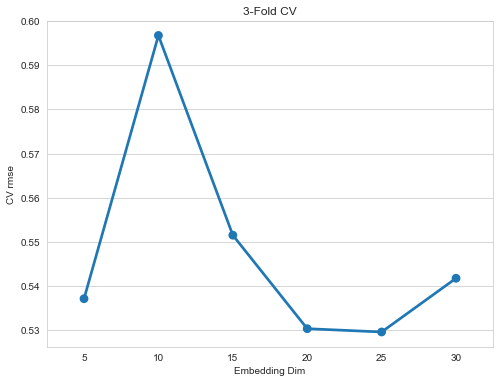

In [24]:
cv_result_df = pd.DataFrame({'cv_rmse': cv_result}, index = embedding_layers)

fig, ax = plt.subplots(figsize=(8, 6))
sns.set_style('whitegrid')
sns.pointplot(x=cv_result_df.index, y=cv_result_df.cv_rmse, ax=ax)
ax.set(xlabel='Embedding Dim', ylabel='CV rmse', title='3-Fold CV')

#### Top 20 recommendations

In [114]:
# input: a recommendation model (keras model), user id, number of recommendation
# output: a dataframe of top-k recommendations along with movie information
def NCF_recommendation(rec_model, client_id, top_k = 20):
    client_encoded = user2user_encoded[client_id]
    movie_watched = sample_df[sample_df['userId'] == client_id]['movieId'].values
    
    movie_poll_encoded = []
    for item in movie_ids:
        if not np.isin(item, movie_watched):
            movie_poll_encoded.append(movie2movie_encoded[item])
            
    d = {'user_encoded': [client_encoded] * len(movie_poll_encoded), 'movie_encoded' : movie_poll_encoded}
    client_df = pd.DataFrame(d)
    
    ratings = rec_model.predict([client_df['user_encoded'], client_df['movie_encoded']])
    
    top_ratings_idx = ratings.flatten().argsort()[-top_k:][::-1]
    top_ratings = ratings[top_ratings_idx].flatten()
    recommend_movieId = [movie_encoded2movie.get(movie_poll_encoded[x]) for x in top_ratings_idx]
    
    top_movie_rec = pd.DataFrame({'movieId': recommend_movieId, 'prediction': top_ratings}).set_index('movieId')
    top_movie_rec = top_movie_rec.join(movie_dt.set_index('movieId'))

    return top_movie_rec

In [244]:
client_id = int(np.random.choice(user_ids, 1))
print(f'recommendation for client: {client_id}')
NCF_recommendation(model, client_id, top_k=15)

recommendation for client: 45817


,prediction,title,genres
movieId,,,
104069,4.061632,Louis C.K.: Oh My God (2013),Comedy
1178,4.005222,Paths of Glory (1957),Drama|War
858,3.944173,"Godfather, The (1972)",Crime|Drama
170705,3.942028,Band of Brothers (2001),Action|Drama|War
2019,3.929219,Seven Samurai (Shichinin no samurai) (1954),Action|Adventure|Drama
159817,3.927687,Planet Earth (2006),Documentary
670,3.912944,"World of Apu, The (Apur Sansar) (1959)",Drama
6818,3.899667,Come and See (Idi i smotri) (1985),Drama|War
1221,3.895232,"Godfather: Part II, The (1974)",Crime|Drama


In [115]:
# input: same as NCF_recommendation
# output: top-k recommendations, recommendations include movies that have been watched
def NCF_recommendation_eval_use_only(rec_model, client_id, top_k = 20):
    client_encoded = user2user_encoded[client_id]
    # movie_watched = sample_df[sample_df['userId'] == client_id]['movieId'].values
    
    movie_poll_encoded = []
    for item in movie_ids:
        #if not np.isin(item, movie_watched):
        movie_poll_encoded.append(movie2movie_encoded[item])
            
    d = {'user_encoded': [client_encoded] * len(movie_poll_encoded), 'movie_encoded' : movie_poll_encoded}
    client_df = pd.DataFrame(d)
    
    ratings = rec_model.predict([client_df['user_encoded'], client_df['movie_encoded']])
    
    top_ratings_idx = ratings.flatten().argsort()[-top_k:][::-1]
    top_ratings = ratings[top_ratings_idx].flatten()
    recommend_movieId = [movie_encoded2movie.get(movie_poll_encoded[x]) for x in top_ratings_idx]
    
    top_movie_rec = pd.DataFrame({'movieId': recommend_movieId, 'prediction': top_ratings}).set_index('movieId')
    top_movie_rec = top_movie_rec.join(movie_dt.set_index('movieId'))

    return top_movie_rec

In [117]:
#client_id = int(np.random.choice(user_ids, 1))
client_id = 45817
print(f'recommendation for client: {client_id}')
NCF_recommendation_eval_use_only(model, client_id, top_k=15)

recommendation for client: 45817


,prediction,title,genres
movieId,,,
104069,4.061632,Louis C.K.: Oh My God (2013),Comedy
1178,4.005222,Paths of Glory (1957),Drama|War
318,3.953702,"Shawshank Redemption, The (1994)",Crime|Drama
1193,3.949498,One Flew Over the Cuckoo's Nest (1975),Drama
858,3.944173,"Godfather, The (1972)",Crime|Drama
170705,3.942028,Band of Brothers (2001),Action|Drama|War
2019,3.929219,Seven Samurai (Shichinin no samurai) (1954),Action|Adventure|Drama
159817,3.927687,Planet Earth (2006),Documentary
670,3.912944,"World of Apu, The (Apur Sansar) (1959)",Drama
